In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns", None)
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
df=pd.read_csv('./dataset/interpolate_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  2140 non-null   object 
 1   avg_price             2140 non-null   float64
 2   active_addresses      2140 non-null   int64  
 3   google_trends         2140 non-null   float64
 4   top100_coins_percent  2140 non-null   float64
 5   avg_polarity          2140 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 100.4+ KB


In [3]:
# get features by slidng window
X=[]
y=[]
timesteps = 30
for row in range(timesteps,2140):
    df_row=df.iloc[(row-timesteps):row]
    # use previous five day's data as features, so there will be 25 features
    # previous five day's avg_price
    f1=df_row['avg_price'].tolist()
    # previous five day's active_addresses
    f2=df_row['active_addresses'].tolist()
    # previous five day's google_trends
    f3=df_row['google_trends'].tolist()
    # previous five day's top100_coins_percent
    f4=df_row['top100_coins_percent'].tolist()
    # previous five day's avg_polarity
    f5=df_row['avg_polarity'].tolist()
    featues=f1+f2+f3+f4+f5
    X.append(featues)
    # label: avg_price
    y.append(df['avg_price'].iloc[row])
# tranfrom X to dataframe
cols1=['avg_price_'+str(i) for i in range(1,timesteps+1)]
cols2=['active_addresses_'+str(i) for i in range(1,timesteps+1)]
cols3=['google_trends_'+str(i) for i in range(1,timesteps+1)]
cols4=['top100_coins_percent_'+str(i) for i in range(1,timesteps+1)]
cols5=['avg_polarity_'+str(i) for i in range(1,timesteps+1)]
X=pd.DataFrame(X,columns=cols1+cols2+cols3+cols4+cols5)
# transform y to series
y=pd.Series(y)

In [4]:
# train set: 1708 test set: 427
X_train=X.iloc[:1708]
X_test=X.iloc[1708:]
y_train=y.iloc[:1708]
y_test=y.iloc[1708:]
feature_columns = X.columns

In [5]:
#z-score normalization
std=StandardScaler()
# fit and transform train set
X_train = std.fit_transform(X_train)
X_train = pd.DataFrame(X_train,columns=feature_columns)
# transform test set
X_test=std.transform(X_test)
X_test = pd.DataFrame(X_test,columns=feature_columns)

In [6]:
# random forest
rf_reg=RandomForestRegressor(n_estimators=200,max_depth=8,random_state=0)
rf_reg.fit(X_train,y_train)

RandomForestRegressor(max_depth=8, n_estimators=200, random_state=0)

In [7]:
# gradient boosting
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=100,min_samples_split=300,max_depth=7,random_state=0,min_samples_leaf=60)
gbr.fit(X_train,y_train)

GradientBoostingRegressor(max_depth=7, min_samples_leaf=60,
                          min_samples_split=300, random_state=0)

In [8]:
# voting of gbr and rf
from sklearn.ensemble import VotingRegressor
vote_reg = VotingRegressor(estimators=[('gbr', GradientBoostingRegressor(n_estimators=100,min_samples_split=300,max_depth=7,random_state=0,min_samples_leaf=60)), ('rf', RandomForestRegressor(n_estimators=200,max_depth=8,random_state=0))])
vote_reg.fit(X_train, y_train)

VotingRegressor(estimators=[('gbr',
                             GradientBoostingRegressor(max_depth=7,
                                                       min_samples_leaf=60,
                                                       min_samples_split=300,
                                                       random_state=0)),
                            ('rf',
                             RandomForestRegressor(max_depth=8,
                                                   n_estimators=200,
                                                   random_state=0))])

In [9]:
# accuracy
def get_accuracy(y_test,y_pred):
    y_test = list(y_test)
    y_pred = list(y_pred)
    return 1 - sum([abs(y_pred[i] - y_test[i])/y_test[i] for i in range(len(y_pred))])/len(y_pred)

In [10]:
# predict
pred_test1=rf_reg.predict(X_test)
# calculate accuracy
accuracy = get_accuracy(y_test,pred_test1)
print('random forest:')
print(f"accuracy:{round(accuracy,4) * 100}%")
print(f"RMSE:{mean_squared_error(y_test,pred_test1,squared=False)}")
print(f"MSE:{mean_squared_error(y_test,pred_test1,squared=True)}")
print(f"R-square:{r2_score(y_test,pred_test1)}")

print('\n')
pred_test2=gbr.predict(X_test)
accuracy = get_accuracy(y_test,pred_test2)
print('gradient boosting regression:')
print(f"accuracy:{round(accuracy,4) * 100}%")
print(f"RMSE:{mean_squared_error(y_test,pred_test2,squared=False)}")
print(f"MSE:{mean_squared_error(y_test,pred_test2,squared=True)}")
print(f"R-square:{r2_score(y_test,pred_test2)}")

print('\n')
pred_test3=vote_reg.predict(X_test)
accuracy = get_accuracy(y_test,pred_test3)
print('voting model (lr,lr,lr) regression:')
print(f"accuracy:{round(accuracy,4) * 100}%")
print(f"RMSE:{mean_squared_error(y_test,pred_test3,squared=False)}")
print(f"MSE:{mean_squared_error(y_test,pred_test3,squared=True)}")
print(f"R-square:{r2_score(y_test,pred_test3)}")

random forest:
accuracy:90.98%
RMSE:2918.997506744741
MSE:8520546.444382012
R-square:0.9573964567335109


gradient boosting regression:
accuracy:89.01%
RMSE:4006.693661999588
MSE:16053594.10110767
R-square:0.9197305014022724


voting model (lr,lr,lr) regression:
accuracy:90.08%
RMSE:3392.4019814765775
MSE:11508391.20392621
R-square:0.9424569485320476


[59037.35817953948, 59930.39958481877, 60200.08024751718, 60152.55162743506, 60485.94443903318, 60777.393533772585, 60813.04492604617, 60099.6262645149, 60632.617116522364, 61304.6646482684, 61066.15304112553, 61073.233219696966, 60525.38923069985, 60398.81218398269, 61192.55178030303]
[56476.97067096923, 57014.11268511758, 56584.431781196006, 56679.44586312429, 56852.7881149341, 57005.673902172566, 57087.19839604224, 57083.577981968025, 57235.90570085021, 57003.86784974785, 56708.185749137185, 56866.71801771787, 56878.342376976645, 57017.733474716646, 57042.531977041006]
[57757.164425254356, 58472.25613496818, 58392.25601435659, 58415.99874527968, 58669.36627698364, 58891.533717972576, 58950.121661044206, 58591.602123241464, 58934.26140868629, 59154.26624900813, 58887.16939513136, 58969.975618707416, 58701.86580383825, 58708.27282934967, 59117.54187867202]
[62611.0, 62362.0, 59558.0, 60198.0, 61532.0, 61625.0, 61102.0, 61287.0, 62481.0, 62829.0, 61830.0, 61493.0, 60938.0, 62105.0, 657

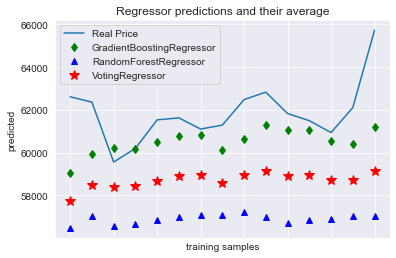

In [11]:
plt.figure()
print(list(pred_test1[20:35]))
print(list(pred_test2[20:35]))
print(list(pred_test3[20:35]))
tests = list(y_test[20:35])
print(tests)
plt.plot(tests,label='Real Price')
plt.plot(pred_test1[20:35], "gd", label="GradientBoostingRegressor")
plt.plot(pred_test2[20:35], "b^", label="RandomForestRegressor")
plt.plot(pred_test3[20:35], "r*", ms=10, label="VotingRegressor")
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Regressor predictions and their average")
plt.savefig(r'D:\semA\COMP 5567\5567project\picture\regressor.png')